In [1]:
import pyVHR as vhr
import numpy as np

#https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec

# Plotting: set 'colab' for Google Colaboratory, 'notebook' otherwise
vhr.plot.VisualizeParams.renderer = 'notebook'  # or 'notebook'
    
#SET DATASET
    
dataset_name = 'pure'          # the name of the python class handling it 
video_DIR = '/var/datasets/VHR1/'  # dir containing videos
BVP_DIR = '/var/datasets/VHR1/'    # dir containing BVPs GT

dataset = vhr.datasets.datasetFactory(dataset_name, videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)
allvideo = dataset.videoFilenames

# print the list of video names with the progressive index (idx)
#for v in range(len(allvideo)):
#  print(v, allvideo[v])

wsize = 8          # seconds of video processed (with overlapping) for each estimate 
video_idx = 0      # index of the video to be processed
fname = dataset.getSigFilename(video_idx)
sigGT = dataset.readSigfile(fname)
test_bvp = sigGT.data
bpmGT, timesGT = sigGT.getBPM(wsize)
videoFileName = dataset.getVideoFilename(video_idx)
print('Video processed name: ', videoFileName)
fps = vhr.extraction.get_fps(videoFileName)
print('Video frame rate:     ',fps)

#vhr.plot.display_video(videoFileName)

2022-04-12 11:48:11.121064: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


/var/datasets/VHR1/PURE
Video processed name:  /var/datasets/VHR1/PURE/06-05/06-05.avi
Video frame rate:      30.0


In [2]:
import matplotlib.pyplot as plt

t = [test_bvp[0][i] for i in range(0,len(test_bvp[0])-1,2)]
print(len(test_bvp[0]))
print(len(t))

3894
1947


In [2]:
#SKIN EXTRACTION AND VISUALIZATION
sig_extractor = vhr.extraction.SignalProcessing()
sig_extractor.set_skin_extractor(vhr.extraction.SkinExtractionConvexHull())
seconds = 0
sig_extractor.set_total_frames(seconds*fps)

vhr.extraction.SkinProcessingParams.RGB_LOW_TH = 2
vhr.extraction.SkinProcessingParams.RGB_HIGH_TH = 254
vhr.extraction.SignalProcessingParams.RGB_LOW_TH = 2
vhr.extraction.SignalProcessingParams.RGB_HIGH_TH = 254
 
sig_extractor.set_visualize_skin_and_landmarks(
      visualize_skin=True, 
      visualize_landmarks=True, 
      visualize_landmarks_number=True, 
      visualize_patch=True)

landmarks = [2, 3, 4, 5, 6, 8, 9, 10, 18, 21, 32, 35, 36, 43, 46, 47, 48, 50, 54, \
             58, 67, 68, 69, 71, 92, 93, 101, 103, 104, 108, 109, 116, 117, \
             118, 123, 132, 134, 135, 138, 139, 142, 148, 149, 150, 151, 152, 182, 187, 188, 193, 197, 201, 205, 206, 207, \
             210, 211, 212, 216, 234, 248, 251, 262, 265, 266, 273, 277, 278, 280, \
             284, 288, 297, 299, 322, 323, 330, 332, 333, 337, 338, 345, \
             346, 361, 363, 364, 367, 368, 371, 377, 379, 411, 412, 417, 421, 425, 426, 427, 430, 432, 436]

print('Num landmarks: ', len(landmarks))
#vhr.plot.visualize_landmarks_list(landmarks_list=landmarks)
sig_extractor.set_landmarks(landmarks)

#PATCHES EXTRACTION

sig_extractor.set_square_patches_side(30.0)
patch_sig = sig_extractor.extract_patches(videoFileName, "squares", "mean")
print('Size: (#frames, #landmarks, #channels) = ', patch_sig.shape)

visualize_patches_coll = sig_extractor.get_visualize_patches()
print('Number of frames processed: ',len(visualize_patches_coll))
#vhr.plot.interactive_image_plot(visualize_patches_coll,1.0)

patches = sig_extractor.patches
print("patches: ", len(patches), len(patches[0]))

Num landmarks:  100


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Size: (#frames, #landmarks, #channels) =  (1959, 100, 3)
Number of frames processed:  1959
patches:  1959 100


(30, 30, 3)


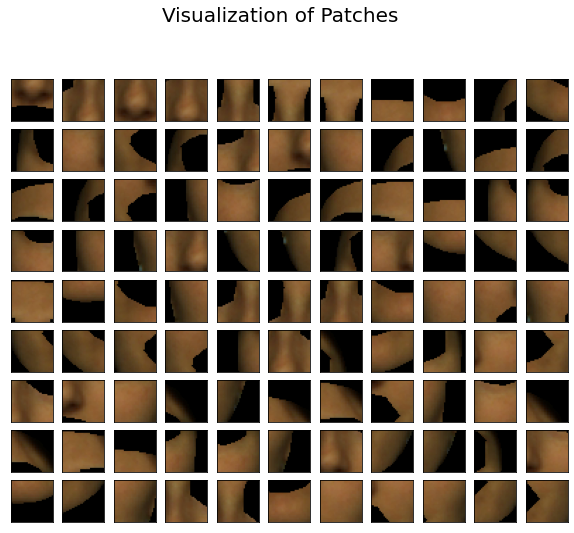

(30, 30, 3)


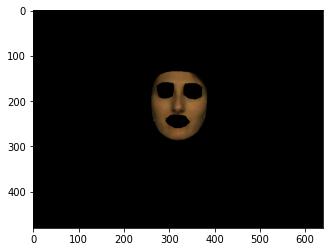

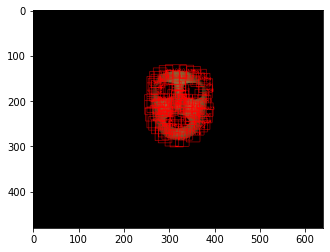

In [3]:
import cv2
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
fig.suptitle("Visualization of Patches", fontsize=20)
print(patches[0][0].shape)
for i in range(0, len(patches[0])-1):
    x = i % 11
    y = i // 11
    #patches[0][i] = cv2.resize(patches[0][i], dsize=(30, 30), interpolation=cv2.INTER_CUBIC)
    ax = fig.add_subplot(11, 11, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patches[0][i])
plt.show()

print(patches[0][i].shape)

plt.imshow(sig_extractor.visualize_skin_collection[0])
plt.show()
plt.imshow(sig_extractor.visualize_landmarks_collection[0])
plt.show()

In [3]:
import cv2

def extract_frames_yield(videoFileName):
    """
    This method yield the frames of a video file name or path.
    """
    vidcap = cv2.VideoCapture(videoFileName)
    success, image = vidcap.read()
    while success:
        yield image
        success, image = vidcap.read()
    vidcap.release()
    
def extract_raw(videoFileName):
        """
        Extracts raw frames from video.
        Args:
            videoFileName (str): video file name or path.
        Returns: 
            ndarray: raw frames with shape [num_frames, height, width, rgb_channels].
        """

        frames = []
        for frame in extract_frames_yield(videoFileName):
                frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))   # convert to RGB

        return np.array(frames)

In [4]:
frames = extract_raw(videoFileName)
frames.shape

(1943, 480, 640, 3)

(1943, 107, 5)
[159 232   0   0   0]
(30, 30, 3)


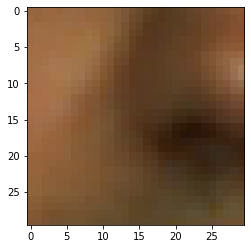

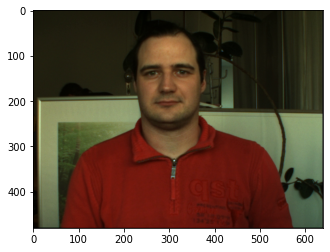

In [8]:
ml=np.asarray(sig_extractor.ml).astype(int)
print(np.asarray(sig_extractor.ml).shape)
print(ml[0][0])
m = ml[0][105]
p = frames[0][m[0]-15:m[0]+15,m[1]-15:m[1]+15]
print(p.shape)
plt.imshow(p)
plt.show()
plt.imshow(frames[0])
plt.show()

In [1]:
import torchvision.transforms as T

p = transforms.Compose([transforms.Scale((224,224))])

# transformed image
img_tensor = transforms(img).unsqueeze(0).to(device) # add a dimension for batch
print('\nTransformed image dims:', img_tensor.shape)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)


NameError: name 'img' is not defined

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


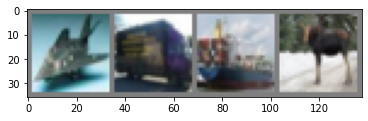

plane truck ship  deer 
[1,  2000] loss: 2.177
[1,  4000] loss: 1.866
[1,  6000] loss: 1.679
[1,  8000] loss: 1.587
[1, 10000] loss: 1.496
[1, 12000] loss: 1.462
[2,  2000] loss: 1.377
[2,  4000] loss: 1.350
[2,  6000] loss: 1.344
[2,  8000] loss: 1.316
[2, 10000] loss: 1.294
[2, 12000] loss: 1.254
Finished Training


In [18]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

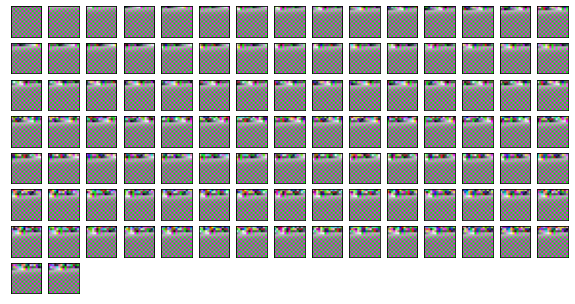

In [4]:
import math
import matplotlib.pyplot as plt
import torch 
import torch.nn.functional as F
import numpy as np

p = 50
embed_dim = 675
n_patches = 107

pe = torch.zeros(1,n_patches, embed_dim)

fig = plt.figure(figsize=(10, 10))

for ldk in range(n_patches):
    for i in range(0, embed_dim-1,2):
        #pe[p,i] = F.cosine_similarity(pe[0, i], pe[0], dim=1)
        pe[0,ldk, i] = math.sin(ldk / (10000 ** ((2 * i)/embed_dim)))
        pe[0,ldk,i + 1] = math.cos(ldk / (10000 ** ((2 * (i + 1))/embed_dim)))
    ax = fig.add_subplot(15, 15, ldk+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(((pe[0,ldk].reshape((15, 15, 3)))*255).detach().cpu().numpy().astype(np.uint8))
        


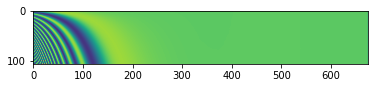

In [5]:
c = []
for ldk in range(n_patches):
    c.append(pe[0,ldk].detach().cpu().numpy())

plt.imshow(np.array(c))
plt.show()